<base target="_blank">
The availability of pretrained language models has increased tremendously in recent years. With the use of the amazing 🤗 Huggingface infrastructure many have finetuned models for downstream classification tasks. The results are often amazing, the accuracy with which these models are able to classify text is impressive. Finetuning a model requires GPU power at your disposal, moreover you need a dataset with labels to train on. However, labels are not always available. If you are working in a company without historical data or well defined labels in your dataset, you are not alone. It is surprisingly common not to have proper labelled data. So chances are that you or your team have not started to extract value out of textual data yet. 

**In this article I will show you how easy it is to use a language model to classify text without any pre-existing labels.** In NLP this is called zero-shot classification: doing it right the first time without any additional training. With zero-shot classification, you use an already trained model to do something the model is not actually trained to do. Because the information contained in the model is so incredibly rich (billions of trained parameters on huge amounts of text), retraining or fine-tuning a model using existing labels is not necessary.

To do this, knowledge from the [Natural Language Inference](http://nlpprogress.com/english/natural_language_inference.html) (NLI) domain is used. NLI models are trained on a task called *text entailment*. In this task two sentences are compared: a premise and a hypothesis. It is then up to the algorithm to assess whether the hypothesis is a logical consequence of the premise, a contradiction or neither (neutral). 

<img src="https://production-media.paperswithcode.com/datasets/Screen_Shot_2021-01-27_at_12.45.57_PM.png"/>

*Snaphot taken from the* [SNLI dataset](https://huggingface.co/datasets/snli). 


### Setting up our tools
In this example I will be using a [NLI model](https://huggingface.co/MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli) suited for zero-shot classification trained on a multilingual [dataset](https://huggingface.co/datasets/cc100). In that way you can follow this example even when you have callcenter or emails at your disposal in other languages. For this example I've gathered 100 customer complaints taken from the US [Consumer Complaints Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). The original dataset has the written complaints, a product label and 20 other features. Here I use only the issued label and the text of the complaint. Keeping the label will enable us to validate how well the zero-shot classifier has done the job. 

In [1]:
%%capture
!pip install transformers[sentencepiece]

In [14]:
# Import HF pipeline for zero-shot-classification
from transformers import pipeline
first_time_right = pipeline("zero-shot-classification", model='MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli', device=0)

Since NLI models are trained using a premise and a hypothesis we use a text sequence as the premise and use a set of possible labels as the hypotheses. In the example below we provide a statement (premise) and use a hypothesis template with all possible labels. The pipeline will provide a probability for each label. When `multi_label` is set to `False` the sum of all probabilities will be 1. 

In [15]:
sequence = "A walk during your lunch break is an excellent way to keep you a vital employee."
candidate_labels = ["politics", "family", "health", "work"]
hypothesis_template = "This statement is about {}"

output = first_time_right(sequence, candidate_labels, hypothesis_template=hypothesis_template, multi_label=False)


The HF pipeline outputs a dictionary containing the inputs (premise and hypothesis with labels) and a score for each label. Let's turn this into a more human readable format. 

In [5]:
# Function ot format the output
def format_pred(input):
  print(f"Premise \t{input['sequence']}")
  print(f"Hypothesis \t{hypothesis_template[:-3]}:")
  for label, score in zip(input['labels'], input['scores']):
   print((f" - {label}:\t {score:.2f}").expandtabs(40))

format_pred(output)   

Premise 	A walk during your lunch break is an excellent way to keep you a vital employee.
Hypothesis 	This statement is about:
 - health:                               0.65
 - work:                                 0.34
 - family:                               0.00
 - politics:                             0.00


Using an existing NLI model not trained for this specific task it is able to see that this premise is primarily about work and about health. Since this model was trained on a multiligual corpus we can easily make the same predictions using a French premise. 

In [ ]:
sequence = "Une promenade pendant votre pause déjeuner est un excellent moyen de maintenir votre vitalité en tant qu'employé."
candidate_labels = ["politics", "family", "health", "work"]
hypothesis_template = "This statement is about {}"

output = first_time_right(sequence, candidate_labels, hypothesis_template=hypothesis_template, multi_label=False)
format_pred(output)

Premise 	Une promenade pendant votre pause déjeuner est un excellent moyen de maintenir votre vitalité en tant qu'employé.
Hypothesis 	This statement is about:
 - health:                               0.55
 - work:                                 0.45
 - family:                               0.00
 - politics:                             0.00


The model will struggle however if the text (premise, hypothesis, labels) provided does not resemble the corpus it was trained on. Less frequently used tokens will not appear in the tokenizer vocabulary making it difficult to distinguish between labels. 

### Classifying real data


Now that you've seen the basics of using a zero-shot classification model, 
let's move on to making predictions on real data. Many companies have textual data at their disposal, for instance call-center logs, surveys, incoming e-mails or an ordersystem with notes. In this example we will work with [complaints received](https://www.consumerfinance.gov/data-research/consumer-complaints/) and registrered in the Consumer Complaint Database. The original dataset has more than 20.000 complaints, for the purpose of this example I will use 100 records. 


In [6]:
import pandas as pd
df = pd.read_csv('account_complaints_sample.csv' , delimiter="|", encoding='utf-8')
df.head(10)

issue_label  \
0        Deposits and withdrawals   
1  Transaction was not authorized   
2        Deposits and withdrawals   
3              Closing an account   
4        Deposits and withdrawals   
5        Deposits and withdrawals   
6              Closing an account   
7        Deposits and withdrawals   
8              Closing an account   
9  Transaction was not authorized   

                                           complaint  
0  On XX/XX/XXXX I filed a claim with Bank of Ame...  
1  I feel that it is because of Associated Bank t...  
2  I went on a trip to visit my family out of sta...  
3  Chase Bank closed my account and is not return...  
4  Yes, so I have the Wells Fargo app on my phone...  
5  On approximately XX/XX/2022, I opened an Alber...  
6  Ally Bank closed my account with no notice and...  
7  Our account was hacked through a scammed XXXX ...  
8  CHase bank closed my debit/checking account i ...  
9  On XX/XX/XXXX at XXXX I logged onto my bank of...

Let's take a look at an example complaint. Personal information, amounts and dates have been masked in this dataset with XX's. Before we use these examples to predict what the complaint is about we need to clean up the input. 

In [7]:
df.iloc[4,1]

'Yes, so I have the Wells Fargo app on my phone I rarely check it my account only when I get paid which I get paid every two weeks. I had recently lost my debit card on Wednesday today is currently thurs. I have been looking for it thats why I didnt call my bank because I didnt want to change up all my information. But today I received an email saying my card was declined I check my email and it says that a withdrawl and deposit was made on my account of XXXX and a withdrawal declined for XXXX I live in XXXX XXXX so it really was gut wrenching when I seen XXXX XXXX. So I immediately called to switch out my card and all my info. I dont know what else they were able to get a hold of. What other information of mine.'

In [8]:
import re
def clean_text(input):
        input = re.sub("\(.*?\)|\{.*?\}", ' ', input) # remove content between {}
        input = re.sub('XXXX', ' ', input) # remove masked names  and years
        input = re.sub('XX/XX/', ' ', input) # remove masked date parts
        input = re.sub('<.*?>', ' ', input) #remove HTML code
        input = re.sub('\n+', ' ', input)  # remove newline chars
        input = re.sub('[0-9]+', ' ', input) # remove numbers
        input = re.sub(" EUR", ' ', input) # remove EUR remainders
        input = re.sub('  ', '', input) # double spaces
        return(input)

Using a simple function to clean up the text yields a much cleaner input text to work with. 

In [9]:
clean_text(df.iloc[4,1])

'Yes, so I have the Wells Fargo app on my phone I rarely check it my account only when I get paid which I get paid every two weeks. I had recently lost my debit card on Wednesday today is currently thurs. I have been looking for it thats why I didnt call my bank because I didnt want to change up all my information. But today I received an email saying my card was declined I check my email and it says that a withdrawl and deposit was made on my account of and a withdrawal declined for I live in so it really was gut wrenching when I seen. So I immediately called to switch out my card and all my info. I dont know what else they were able to get a hold of. What other information of mine.'

In [10]:
# Clean all complaints in our sample
df['complaint_cleaned'] = df['complaint'].apply(clean_text)
df

issue_label  \
0         Deposits and withdrawals   
1   Transaction was not authorized   
2         Deposits and withdrawals   
3               Closing an account   
4         Deposits and withdrawals   
..                             ...   
95  Transaction was not authorized   
96  Transaction was not authorized   
97              Closing an account   
98              Closing an account   
99       Problem accessing account   

                                            complaint  \
0   On XX/XX/XXXX I filed a claim with Bank of Ame...   
1   I feel that it is because of Associated Bank t...   
2   I went on a trip to visit my family out of sta...   
3   Chase Bank closed my account and is not return...   
4   Yes, so I have the Wells Fargo app on my phone...   
..                                                ...   
95  On Saturday, XX/XX/2021 my husband and I recei...   
96  To whom it may concern, I have contacted Capit...   
97  Im filing a complaint against fifth third bank...   
98  Mt & t bank balance due {$620.00} someone went...   
99  On XX/XX/2022 at around XXXX XXXX I tried abou...   

                                    complaint_cleaned  
0   OnI filed a claim with Bank of America after d...  
1   I feel that it is because of Associated Bank t...  
2   I went on a trip to visit my family out of sta...  
3   Chase Bank closed my account and is not return...  
4   Yes, so I have the Wells Fargo app on my phone...  
..                                                ...  
95  On Saturday,my husband and I received a letter...  
96  To whom it may concern, I have contacted Capit...  
97  Im filing a complaint against fifth third bank...  
98  Mt & t bank balance due someone went to the te...  
99  Onat around I tried about TIMES to access my a...  

[100 rows x 3 columns]

Next we look at the labels that were already provided to the complaints by the bank that handled the complaint. In this selection we have four different types of complaints: 1) there was a complaint about a deposit or withdrawal, 2) an unauthorized transaction took place, 3) a complaint about closing an account and 4) a complaint about the ability to get access to the account. 

In [ ]:
# What are possible issue values?
df['issue_label'].unique()

array(['Deposits and withdrawals', 'Transaction was not authorized',
       'Closing an account', 'Problem accessing account'], dtype=object)

Below the labels are altered a bit to reflect a readable hypothesis. In that way the text of the complaint is used as the premise and the hypothesis is constructed like 'This is a customer complaint about closing the account.' It might be possbile that these complaints have multiple correct labels. A complaint can be on both a withdrawal and an unauthorized transaction. Therefore we will use a multilabel output. 

In [16]:
sequence = df.iloc[2,2]
candidate_labels = ['closing the account', 'online login to account', 'a deposit or withdrawal', 'an unauthorized transaction']
hypothesis_template = "This is a customer complaint about {}"

output = first_time_right(sequence, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
format_pred(output)

Premise 	I went on a trip to visit my family out of state. When I returned someone broke into my hose and took documents and everything of value. Not only did they take my documents they found a way to get into my bank account and steal my money without me knowing. They accessed my account and took out over dollars. It is my savings and all of the money I have. I tried to tell the bank it was stolen but they say I did it! When I was out of state! The bank says I let someone take my information and they will not help me get my money back. I filled a police report and they still will not listen.
Hypothesis 	This is a customer complaint about:
 - an unauthorized transaction:          1.00
 - online login to account:              0.64
 - a deposit or withdrawal:              0.21
 - closing the account:                  0.00


In this blog we have 100 example records in our dataset. It would be great to have all these examples classified in one go. The function below takes care of this and adds a progress indicator as well. If you use a GPU enabled environment and a lot of examples it might be wise to use a [Huggingface Dataset](https://huggingface.co/course/chapter5/4?fw=pt) to perform the scoring. This will send batch-wise records to the GPU. In our example, with just a few records, feeding the examples one-by-one to either the CPU of GPU will work just fine. 

The function below will hold all the label scores in a Pandas dataframe so we can easily compare results afterwards. 



In [17]:
# Add a progress bar
from tqdm import tqdm

# Function for looping through all records in the dataframe, the input column should have the name 'complaint_cleaned'
def classify_all_complaints(df, candidate_labels, hypothesis_template):
    
    for i in tqdm(range(0, df.shape[0])):
        complaint = df.loc[i, 'complaint_cleaned']
        if complaint is not None:
            pd.options.mode.chained_assignment = None
            result = first_time_right(complaint, candidate_labels=candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)

            df.loc[i, 'label_1'] = result['labels'][0]
            df.loc[i, 'score_1'] = result['scores'][0]
            df.loc[i, 'label_2'] = result['labels'][1]
            df.loc[i, 'score_2'] = result['scores'][1]
            df.loc[i, 'label_3'] = result['labels'][2]
            df.loc[i, 'score_3'] = result['scores'][2]
                
    return df

In [18]:
# Execute function on 100-record sample set
df_result = classify_all_complaints(df.drop('complaint', axis=1), candidate_labels, hypothesis_template)

  8%|▊         | 8/100 [00:03<00:34,  2.68it/s]/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1046: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Now that we have the results for our 100 examples we can compare them to the origin labels to see how well the zeroshot model has performed. To be able to make this comparison we need to rename the output to the original labels. The result is stored in the column pred_label.  

Please note that in this example I use existing labels to verify how well an untrained model is able to categorize the complaints in different buckets. Using a zeroshot pipeline is very much suitable when you want to classify text in a number of self chosen categories. So here I use existing labels but for your use case you can choose any labels that you want. Test to see what works out best for you.  

In [19]:
# Rename candidate labels so we get  labels to compare to the original input

rename = {'closing the account': 'Closing an account' ,
          'online login to account': 'Problem accessing account' 
          , 'a deposit or withdrawal': 'Deposits and withdrawals' 
          , 'an unauthorized transaction': 'Transaction was not authorized' 
          }

df_result['pred_label'] = df_result['label_1'].map(rename)
df_result

issue_label  \
0         Deposits and withdrawals   
1   Transaction was not authorized   
2         Deposits and withdrawals   
3               Closing an account   
4         Deposits and withdrawals   
..                             ...   
95  Transaction was not authorized   
96  Transaction was not authorized   
97              Closing an account   
98              Closing an account   
99       Problem accessing account   

                                    complaint_cleaned  \
0   OnI filed a claim with Bank of America after d...   
1   I feel that it is because of Associated Bank t...   
2   I went on a trip to visit my family out of sta...   
3   Chase Bank closed my account and is not return...   
4   Yes, so I have the Wells Fargo app on my phone...   
..                                                ...   
95  On Saturday,my husband and I received a letter...   
96  To whom it may concern, I have contacted Capit...   
97  Im filing a complaint against fifth third bank...   
98  Mt & t bank balance due someone went to the te...   
99  Onat around I tried about TIMES to access my a...   

                        label_1   score_1                      label_2  \
0       a deposit or withdrawal  0.999305  an unauthorized transaction   
1   an unauthorized transaction  0.999494      a deposit or withdrawal   
2   an unauthorized transaction  0.999769      online login to account   
3           closing the account  0.999196  an unauthorized transaction   
4   an unauthorized transaction  0.999745      a deposit or withdrawal   
..                          ...       ...                          ...   
95  an unauthorized transaction  0.999195      a deposit or withdrawal   
96  an unauthorized transaction  0.460094      a deposit or withdrawal   
97  an unauthorized transaction  0.995746      a deposit or withdrawal   
98  an unauthorized transaction  0.998349      a deposit or withdrawal   
99      online login to account  0.999383  an unauthorized transaction   

     score_2                  label_3   score_3  \
0   0.997826  online login to account  0.000327   
1   0.999322      closing the account  0.031781   
2   0.644791  a deposit or withdrawal  0.213802   
3   0.875042  a deposit or withdrawal  0.024322   
4   0.999496  online login to account  0.731411   
..       ...                      ...       ...   
95  0.864587      closing the account  0.052015   
96  0.000885  online login to account  0.000638   
97  0.857804      closing the account  0.122485   
98  0.976690      closing the account  0.001808   
99  0.001157  a deposit or withdrawal  0.000997   

                        pred_label  
0         Deposits and withdrawals  
1   Transaction was not authorized  
2   Transaction was not authorized  
3               Closing an account  
4   Transaction was not authorized  
..                             ...  
95  Transaction was not authorized  
96  Transaction was not authorized  
97  Transaction was not authorized  
98  Transaction was not authorized  
99       Problem accessing account  

[100 rows x 9 columns]

Now we can use a basic classification report from sci-kit learn to get some statistics on the predicted labels. The overall precision 76,8% and the recall 67%, not bad for a model that was not trained for this specific use case. 

In [20]:
import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score
true_label = np.array(df_result['issue_label'])
pred_label = np.array(df_result['pred_label'])
clf = classification_report(true_label, pred_label, zero_division=0, output_dict=True)

In [21]:
clf['weighted avg']

{'precision': 0.7680106951871657,
 'recall': 0.67,
 'f1-score': 0.6712357723577236,
 'support': 100}

Using a visualisation of the confusion matrix we can see the category 'Unauthorized transaction' was often predicted for other labels as well, which might be the case in reality. 

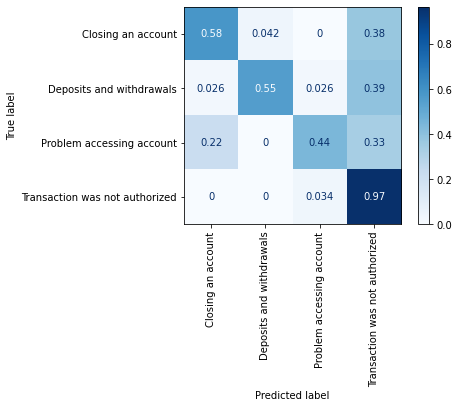

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_label, pred_label, normalize='true', xticks_rotation='vertical', cmap='Blues')

In this blog I've showed you how to use an existing language model to perform a task it was not trained to do using the Huggingface zeroshot pipeline. In this case I've used a well performing general model to classify the complaints database examples. If you want to try to classify text using a zeroshot approach, please take a look on the [Huggingface models tab](https://huggingface.co/models?pipeline_tag=zero-shot-classification&sort=downloads) and look for models that were trained on text that resembles your use case the most. The dataset I used can be downloaded from Gitlab [here](https://gitlab.com/cmotions/publications/-/tree/main/Zeroshot%20NLP), the 100 case sample is available as well as a 10.000 case csv file (records use a pipe-separator |). 